In [17]:
import numpy as np
import tensorflow as tf
import glob 
import pandas as pd
import h5py # import to read hdf5
from pathlib import Path
from tqdm import tqdm
# Load train_test_split from sklearn
from sklearn.model_selection import train_test_split
import random
import matplotlib.pyplot as plt

In [10]:
# root = "/Volumes/T7/gravitational-waves/kaggle-data"
root = "/media/viktor/T7/gravitational-waves"

def load_df(train=True):
    
    if train:
        # Load /Users/viktorcikojevic/Documents/gravitational-waves-detection-kaggle/train_labels.csv as pandas dataframe
        df = pd.read_csv(f'{root}/kaggle-data/train_labels.csv')
        root_folder = f"{root}/kaggle-data/train"
        # Rename the column 'id' to 'filename'. Add "root_folder" to the beginning of the filename
        df['filename'] = root_folder + "/" + df['id'].astype(str) + ".hdf5"

    else:
        df = pd.DataFrame({'filename': glob.glob(f'{root}/kaggle-data/test/*.hdf5')})
    return df

In [11]:
df = load_df(train=True)
df.head(5)

,id,target,filename
0,001121a05,1,/media/viktor/T7/gravitational-waves/kaggle-da...
1,004f23b2d,1,/media/viktor/T7/gravitational-waves/kaggle-da...
2,00a6db666,1,/media/viktor/T7/gravitational-waves/kaggle-da...
3,00f36a6ac,1,/media/viktor/T7/gravitational-waves/kaggle-da...
4,010a387db,1,/media/viktor/T7/gravitational-waves/kaggle-da...


In [12]:

# Each vector x has shape (4, 360, N). If N is not a multiple of 360, then we need to pad the vector with random noise with mu=np.average(x) and sigma=np.std(x)
def pad_amplitudes(x1, x2):
    # Get the shape of the vectors
    shape1 = x1.shape
    shape2 = x2.shape
    # Get the number of elements in each vector
    n1 = shape1[1]
    n2 = shape2[1]
    # Get the number of elements to pad
    n_pad = abs(n1 - n2)
    # Get the average and std of each vector
    mu1 = np.average(x1)
    mu2 = np.average(x2)
    sigma1 = np.std(x1)
    sigma2 = np.std(x2)
    # Get the padding vector
    pad1 = np.random.normal(mu1, sigma1, (360, n_pad))
    pad2 = np.random.normal(mu2, sigma2, (360, n_pad))
    # Pad the shorter vector
    if n1 > n2:
        x2 = np.concatenate((x2, pad2), axis=1)
    else:
        x1 = np.concatenate((x1, pad1), axis=1)
    return x1, x2



def combine_amplitudes(amplitude_0, amplitude_1):
    
    amplitude_0, amplitude_1 = pad_amplitudes(amplitude_0, amplitude_1)
    # Get the real part of the amplitudes
    real_0 = amplitude_0.real
    real_1 = amplitude_1.real
    # Get the imaginary part of the amplitudes
    imag_0 = amplitude_0.imag
    imag_1 = amplitude_1.imag
    # normalize the amplitudes to be between 0 and 1
    real_0 = (real_0 - real_0.min()) / (real_0.max() - real_0.min())
    real_1 = (real_1 - real_1.min()) / (real_1.max() - real_1.min())
    imag_0 = (imag_0 - imag_0.min()) / (imag_0.max() - imag_0.min())
    imag_1 = (imag_1 - imag_1.min()) / (imag_1.max() - imag_1.min())
    # Expand the dims of the real and imaginary parts
    real_0 = np.expand_dims(real_0, axis=0)
    real_1 = np.expand_dims(real_1, axis=0)
    imag_0 = np.expand_dims(imag_0, axis=0)
    imag_1 = np.expand_dims(imag_1, axis=0)
    # Make a vstack of the amplitudes
    amplitudes = np.vstack((real_0, imag_0, real_1, imag_1))
    return amplitudes



# Idea from this function takes from this notebook (😇): https://www.kaggle.com/code/ayuraj/g2net-understand-the-data
def preprocess(file):
    file = Path(file)
    with h5py.File(file, "r") as f:
        filename = file.stem
        f = f[filename]
        h1 = f["H1"]
        l1 = f["L1"]
        freq_hz = list(f["frequency_Hz"])
        
        h1_stft = h1["SFTs"][()]
        h1_timestamp = h1["timestamps_GPS"][()]
        # H2 data
        l1_stft = l1["SFTs"][()]
        l1_timestamp = l1["timestamps_GPS"][()]
        
        return combine_amplitudes(h1_stft, l1_stft)

In [20]:
avg = []
stddev = []
for file in tqdm(df['filename']):
    x = preprocess(file).flatten()
    avg.append(np.average(x))
    stddev.append(np.std(x))    

  0%|          | 0/603 [00:00<?, ?it/s]/tmp/ipykernel_150907/1080001032.py:17: ComplexWarning: Casting complex values to real discards the imaginary part
  pad1 = np.random.normal(mu1, sigma1, (360, n_pad))
/tmp/ipykernel_150907/1080001032.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  pad2 = np.random.normal(mu2, sigma2, (360, n_pad))
100%|██████████| 603/603 [01:38<00:00,  6.15it/s]


(0.09, 0.11)

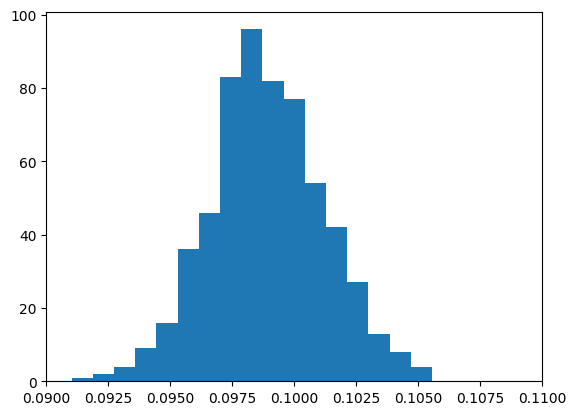

In [23]:
# Plot histogram of stddev
_ = plt.hist(stddev, bins=100)
plt.xlim(0.09, 0.11)